# Streetcar Delay Prediction

Use dataset covering Toronto Transit Commission (TTC) streetcar delays 2014 - 2018 to predict future delays and come up with recommendations for avoiding delays.

Source dataset: : https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#e8f359f0-2f47-3058-bf64-6ec488de52da

In [59]:
! pwd

/home/paperspace/fastai/courses/streetcar


# Load and Save Data
- parse list of XLS files 
- load XLS files, tab by tab, into dataframe
- pickle dataframe for future runs

In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import datetime


In [61]:
path = '../datasets/'

In [62]:
#path = os.getcwd()
def get_xls_list(path):
    # path = '../datasets/'
    files = os.listdir(path)
    files_xls = [f for f in files if f[-4:] == 'xlsx']
    print(files)
    print(files_xls)
    return(files_xls)


In [63]:
def load_xls(path, files_xls, df):
    for f in files_xls:
        print("file name",f)
        xlsf = pd.ExcelFile(path+f)
        # iterate through sheets
        for sheet_name in xlsf.sheet_names:
            # df = pd.read_excel(file_name, sheetname="house")
            print("sheet_name",sheet_name)
            if (f != 'Streetcar 2014.xlsx') or (sheet_name != 'Jan 2014'):
                print("sheet_name in loop",sheet_name)
                data = pd.read_excel(path+f,sheetname=sheet_name)    
                df = df.append(data)
    return (df)

In [64]:
def reloader(path,picklename):
    # get list of all xls files in the path
    files_xls = get_xls_list(path)
    print("list of xls",files_xls)
    # seed initial tab on initial xls file
    dfnew = pd.read_excel(path+'Streetcar 2014.xlsx')
    # load the remaining tabs from all the other xls
    dflatest = load_xls(path,files_xls,dfnew)
    # save dataframe to pickle
    dflatest.to_pickle("../'+ picklename")
    # return dataframe loaded with all tabs of all xls files
    return(dflastest)
    

# Load dataframe and add columns for time series manipulation
- load pickled dataframe
- show info about the dataset
- build index combining date+time along with labelled column date+time


In [65]:
# read in previously pickled dataframe containing data from s/s 2014 - 2018
unpickled_df = pd.read_pickle("/home/paperspace/data/streetcar/20142018_0930.pkl")

In [66]:
unpickled_df.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,2014-01-02,505,06:31:00,Thursday,Dundas and Roncesvalles,Late Leaving Garage,4.0,8.0,E/B,4018.0
1,2014-01-02,504,12:43:00,Thursday,King and Shaw,Utilized Off Route,20.0,22.0,E/B,4128.0
2,2014-01-02,501,14:01:00,Thursday,Kingston road and Bingham,Held By,13.0,19.0,W/B,4016.0
3,2014-01-02,504,14:22:00,Thursday,King St. and Roncesvalles Ave.,Investigation,7.0,11.0,W/B,4175.0
4,2014-01-02,504,16:42:00,Thursday,King and Bathurst,Utilized Off Route,3.0,6.0,E/B,4080.0


In [67]:
unpickled_df.shape

(60717, 10)

In [68]:
unpickled_df.tail()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
1693,2017-12-31,501,19:58:00,Sunday,Queen,General Delay,7.0,15.0,B/W,NaN
1694,2017-12-31,501,21:15:00,Sunday,Queen and Neville park,Mechanical,12.0,24.0,W/B,4110.0
1695,2017-12-31,501,21:44:00,Sunday,Queen and Dufferin,Mechanical,12.0,24.0,W/B,1419.0
1696,2017-12-31,510,22:15:00,Sunday,Spadina and King,Mechanical,5.0,10.0,S/B,4447.0
1697,2017-12-31,505,22:30:00,Sunday,Broadview and Gerrard,Mechanical,8.0,16.0,N/B,4167.0


In [69]:
df = unpickled_df
df.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,2014-01-02,505,06:31:00,Thursday,Dundas and Roncesvalles,Late Leaving Garage,4.0,8.0,E/B,4018.0
1,2014-01-02,504,12:43:00,Thursday,King and Shaw,Utilized Off Route,20.0,22.0,E/B,4128.0
2,2014-01-02,501,14:01:00,Thursday,Kingston road and Bingham,Held By,13.0,19.0,W/B,4016.0
3,2014-01-02,504,14:22:00,Thursday,King St. and Roncesvalles Ave.,Investigation,7.0,11.0,W/B,4175.0
4,2014-01-02,504,16:42:00,Thursday,King and Bathurst,Utilized Off Route,3.0,6.0,E/B,4080.0


In [70]:
# getting some information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60717 entries, 0 to 1697
Data columns (total 10 columns):
Report Date    60717 non-null datetime64[ns]
Route          60717 non-null int64
Time           60717 non-null object
Day            60717 non-null object
Location       60507 non-null object
Incident       60717 non-null object
Min Delay      60699 non-null float64
Min Gap        60699 non-null float64
Direction      60560 non-null object
Vehicle        56484 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 5.1+ MB


In [71]:
# getting some information about dataset
df.shape

(60717, 10)

In [72]:
# further Analysis 
df.describe()

,Route,Min Delay,Min Gap,Vehicle
count,60717.000000,60699.000000,60699.000000,56484.000000
mean,501.115042,12.775664,18.227879,4360.431273
std,41.746424,30.189318,34.508445,1521.572998
min,1.000000,0.000000,0.000000,0.000000
25%,501.000000,5.000000,9.000000,4072.750000
50%,505.000000,6.000000,12.000000,4154.000000
75%,509.000000,12.000000,20.000000,4234.000000
max,999.000000,1400.000000,4216.000000,163242.000000


In [73]:
df.dtypes

Report Date    datetime64[ns]
Route                   int64
Time                   object
Day                    object
Location               object
Incident               object
Min Delay             float64
Min Gap               float64
Direction              object
Vehicle               float64
dtype: object

In [74]:
# create new column combing date + time (needed for resampling) and make it the index

df['Report Date Time'] = pd.to_datetime(df['Report Date'].astype(str) + ' ' + df['Time'].astype(str))
df.index = df['Report Date Time']
df.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time
Report Date Time,,,,,,,,,,,
2014-01-02 06:31:00,2014-01-02,505,06:31:00,Thursday,Dundas and Roncesvalles,Late Leaving Garage,4.0,8.0,E/B,4018.0,2014-01-02 06:31:00
2014-01-02 12:43:00,2014-01-02,504,12:43:00,Thursday,King and Shaw,Utilized Off Route,20.0,22.0,E/B,4128.0,2014-01-02 12:43:00
2014-01-02 14:01:00,2014-01-02,501,14:01:00,Thursday,Kingston road and Bingham,Held By,13.0,19.0,W/B,4016.0,2014-01-02 14:01:00
2014-01-02 14:22:00,2014-01-02,504,14:22:00,Thursday,King St. and Roncesvalles Ave.,Investigation,7.0,11.0,W/B,4175.0,2014-01-02 14:22:00
2014-01-02 16:42:00,2014-01-02,504,16:42:00,Thursday,King and Bathurst,Utilized Off Route,3.0,6.0,E/B,4080.0,2014-01-02 16:42:00


# Create dataframes for delay-duration based forecasting
- create a dataframe with just index and delay
- resample to get mean by month in year

In [75]:
# new = old[['A', 'C', 'D']].copy()
# new dataframe with just Min Delay column
dfstrip = df[['Min Delay']].copy()
dfstrip.head()

,Min Delay
Report Date Time,
2014-01-02 06:31:00,4.0
2014-01-02 12:43:00,20.0
2014-01-02 14:01:00,13.0
2014-01-02 14:22:00,7.0
2014-01-02 16:42:00,3.0


In [76]:
dfmonthav = dfstrip.resample('M').mean()
dfmonthav.head()

,Min Delay
Report Date Time,
2014-01-31,7.862069
2014-02-28,14.117978
2014-03-31,12.590446
2014-04-30,12.645763
2014-05-31,12.280083


In [77]:
# df3['new'] = df3.index
dfmonthav['Report Date Time'] = dfmonthav.index

In [78]:
dfmonthav.tail()

,Min Delay,Report Date Time
Report Date Time,,
2018-03-31,15.063849,2018-03-31
2018-04-30,10.744763,2018-04-30
2018-05-31,9.803109,2018-05-31
2018-06-30,9.772414,2018-06-30
2018-07-31,11.716491,2018-07-31


# Create dataframe for delay count based forecasting


In [79]:
df.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time
Report Date Time,,,,,,,,,,,
2014-01-02 06:31:00,2014-01-02,505,06:31:00,Thursday,Dundas and Roncesvalles,Late Leaving Garage,4.0,8.0,E/B,4018.0,2014-01-02 06:31:00
2014-01-02 12:43:00,2014-01-02,504,12:43:00,Thursday,King and Shaw,Utilized Off Route,20.0,22.0,E/B,4128.0,2014-01-02 12:43:00
2014-01-02 14:01:00,2014-01-02,501,14:01:00,Thursday,Kingston road and Bingham,Held By,13.0,19.0,W/B,4016.0,2014-01-02 14:01:00
2014-01-02 14:22:00,2014-01-02,504,14:22:00,Thursday,King St. and Roncesvalles Ave.,Investigation,7.0,11.0,W/B,4175.0,2014-01-02 14:22:00
2014-01-02 16:42:00,2014-01-02,504,16:42:00,Thursday,King and Bathurst,Utilized Off Route,3.0,6.0,E/B,4080.0,2014-01-02 16:42:00


In [80]:
dfstrip.head()

,Min Delay
Report Date Time,
2014-01-02 06:31:00,4.0
2014-01-02 12:43:00,20.0
2014-01-02 14:01:00,13.0
2014-01-02 14:22:00,7.0
2014-01-02 16:42:00,3.0


In [81]:
dfmonthcount = dfstrip.resample('M').count()
# df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
dfmonthcount = dfmonthcount.rename(columns={'Min Delay':'Delay Count'})
dfmonthcount.head()

,Delay Count
Report Date Time,
2014-01-31,319
2014-02-28,178
2014-03-31,1277
2014-04-30,1180
2014-05-31,964


In [82]:
dfmonthcount['Report Date Time'] = dfmonthcount.index
dfmonthcount.head()

,Delay Count,Report Date Time
Report Date Time,,
2014-01-31,319,2014-01-31
2014-02-28,178,2014-02-28
2014-03-31,1277,2014-03-31
2014-04-30,1180,2014-04-30
2014-05-31,964,2014-05-31


In [83]:
# merged_data = merged_data.join(dm_cases.set_index('CASE_NUMBER'), on = 'CASE_NUMBER')
dfmonthav = dfmonthav.join(dfmonthcount, on='Report Date Time',lsuffix='_left', rsuffix='_right')
dfmonthav.head()

,Min Delay,Report Date Time_left,Delay Count,Report Date Time_right
Report Date Time,,,,
2014-01-31,7.862069,2014-01-31,319,2014-01-31
2014-02-28,14.117978,2014-02-28,178,2014-02-28
2014-03-31,12.590446,2014-03-31,1277,2014-03-31
2014-04-30,12.645763,2014-04-30,1180,2014-04-30
2014-05-31,12.280083,2014-05-31,964,2014-05-31


In [84]:
dfmonthav.head()

,Min Delay,Report Date Time_left,Delay Count,Report Date Time_right
Report Date Time,,,,
2014-01-31,7.862069,2014-01-31,319,2014-01-31
2014-02-28,14.117978,2014-02-28,178,2014-02-28
2014-03-31,12.590446,2014-03-31,1277,2014-03-31
2014-04-30,12.645763,2014-04-30,1180,2014-04-30
2014-05-31,12.280083,2014-05-31,964,2014-05-31


In [85]:
dfmonthav = dfmonthav.rename(columns={'Report Date Time_left':'Report Date Time'})
dfmonthav.drop(['Report Date Time_right'],axis=1)
dfmonthav.head()

,Min Delay,Report Date Time,Delay Count,Report Date Time_right
Report Date Time,,,,
2014-01-31,7.862069,2014-01-31,319,2014-01-31
2014-02-28,14.117978,2014-02-28,178,2014-02-28
2014-03-31,12.590446,2014-03-31,1277,2014-03-31
2014-04-30,12.645763,2014-04-30,1180,2014-04-30
2014-05-31,12.280083,2014-05-31,964,2014-05-31


In [86]:
dfmonthav.drop(['Report Date Time_right'],axis=1)
dfmonthav.head()

,Min Delay,Report Date Time,Delay Count,Report Date Time_right
Report Date Time,,,,
2014-01-31,7.862069,2014-01-31,319,2014-01-31
2014-02-28,14.117978,2014-02-28,178,2014-02-28
2014-03-31,12.590446,2014-03-31,1277,2014-03-31
2014-04-30,12.645763,2014-04-30,1180,2014-04-30
2014-05-31,12.280083,2014-05-31,964,2014-05-31


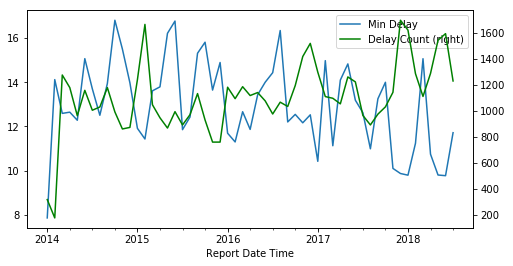

In [87]:
dfmonthav['Min Delay'].plot(legend=True)
# df.B.plot(secondary_y=True, style='g')
dfmonthav['Delay Count'].plot(secondary_y=True, style='g',legend=True)

In [88]:
#ax.set_ylabel('Average Delay')
#ax.right_ax.set_ylabel('Number of delays')
plt.rcParams["figure.figsize"] = [8,4]
plt.show()

# Time Series Forecasting
**Trend**:- As the name suggests trend depicts the variation in the output as time increases.It is often non-linear. Sometimes we will refer to trend as “changing direction” when it might go from an increasing trend to a decreasing trend.

**Level**:- It basically depicts baseline value for the time series.

**Seasonal**:- As its name depicts it shows the repeated pattern over time. In layman terms, it shows the seasonal variation of data over time.

**Noise**:- It is basically external noises that vary the data randomly.

In [89]:
dfmonthav.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55 entries, 2014-01-31 to 2018-07-31
Freq: M
Data columns (total 4 columns):
Min Delay                 55 non-null float64
Report Date Time          55 non-null datetime64[ns]
Delay Count               55 non-null int64
Report Date Time_right    55 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 2.1 KB


In [90]:
# add a column to make scatter plot by month convenient
dfmonthav['Month'] = dfmonthav['Report Date Time'].dt.month
dfmonthav.head(20)

,Min Delay,Report Date Time,Delay Count,Report Date Time_right,Month
Report Date Time,,,,,
2014-01-31,7.862069,2014-01-31,319,2014-01-31,1
2014-02-28,14.117978,2014-02-28,178,2014-02-28,2
2014-03-31,12.590446,2014-03-31,1277,2014-03-31,3
2014-04-30,12.645763,2014-04-30,1180,2014-04-30,4
2014-05-31,12.280083,2014-05-31,964,2014-05-31,5
2014-06-30,15.066437,2014-06-30,1159,2014-06-30,6
2014-07-31,13.701789,2014-07-31,1006,2014-07-31,7
2014-08-31,12.505335,2014-08-31,1031,2014-08-31,8
2014-09-30,13.942373,2014-09-30,1180,2014-09-30,9


In [91]:
dfmonthav.head(20)

,Min Delay,Report Date Time,Delay Count,Report Date Time_right,Month
Report Date Time,,,,,
2014-01-31,7.862069,2014-01-31,319,2014-01-31,1
2014-02-28,14.117978,2014-02-28,178,2014-02-28,2
2014-03-31,12.590446,2014-03-31,1277,2014-03-31,3
2014-04-30,12.645763,2014-04-30,1180,2014-04-30,4
2014-05-31,12.280083,2014-05-31,964,2014-05-31,5
2014-06-30,15.066437,2014-06-30,1159,2014-06-30,6
2014-07-31,13.701789,2014-07-31,1006,2014-07-31,7
2014-08-31,12.505335,2014-08-31,1031,2014-08-31,8
2014-09-30,13.942373,2014-09-30,1180,2014-09-30,9


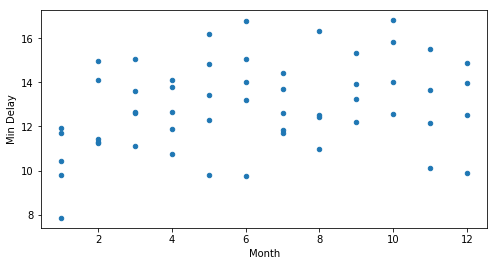

In [92]:
# scatter plot to show mean delay in same month across years
dfmonthav.plot.scatter(x = 'Month', y = 'Min Delay')
plt.show()

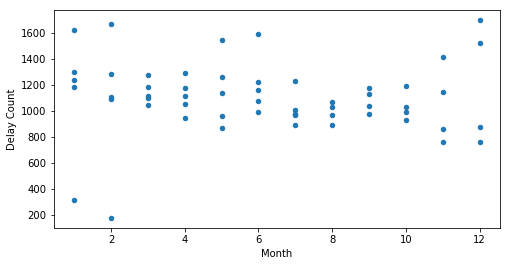

In [93]:
# scatter plot to show delay count in same month across years
dfmonthav.plot.scatter(x = 'Month', y = 'Delay Count')
plt.show()

# Trend Analysis

Use the rolling method which is inbuilt in pandas for smoothing.

For trend analysis, we use smoothing techniques. 
- In statistics smoothing a data set means to create an approximating function that attempts to capture important patterns in the data, while leaving out noise or other fine-scale structures/rapid phenomena. 
- In smoothing, the data points of a signal are modified so individual points (presumably because of noise) are reduced, and points that are lower than the adjacent points are increased leading to a smoother signal. 

We implement smoothing by taking moving averages. [Exponential moving average](https://www.investopedia.com/terms/e/ema.asp) is frequently used to compute smoothed function.

In [94]:
mean_delay = dfmonthav[['Min Delay']]
count_delay = dfmonthav[['Delay Count']]

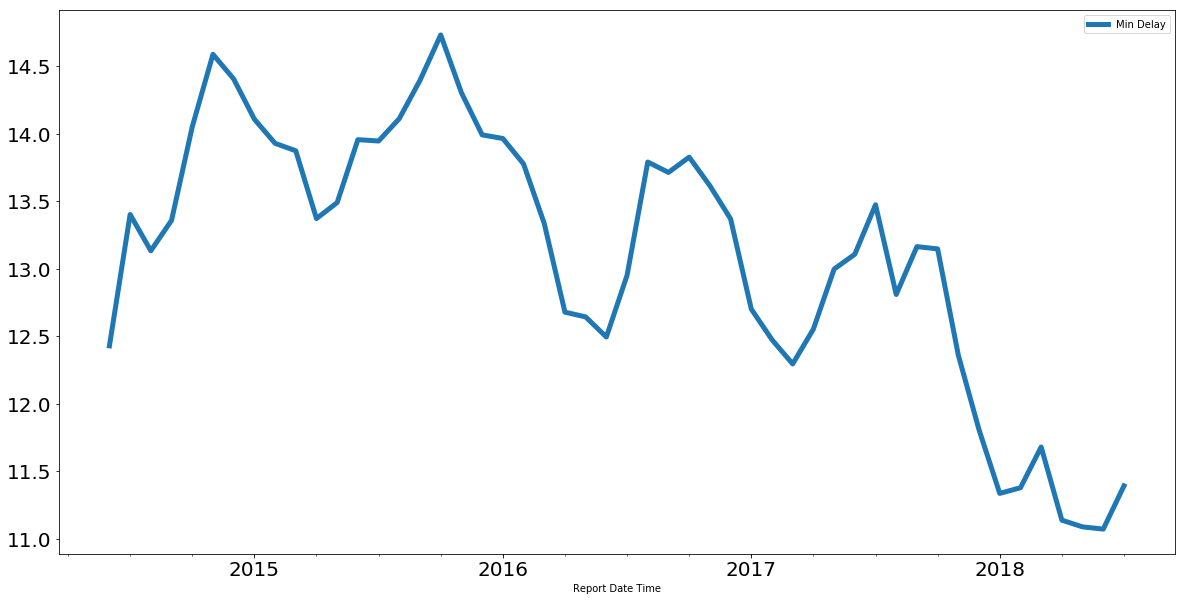

In [95]:
mean_delay.rolling(6).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

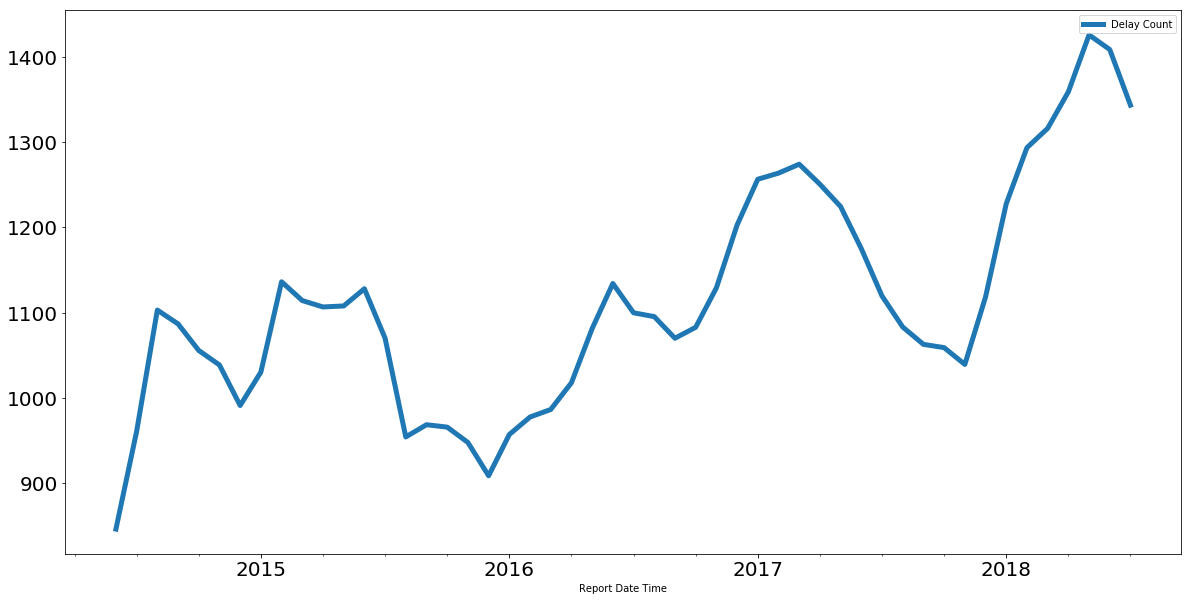

In [96]:
count_delay.rolling(6).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

## Seasonability Analysis

Two most famous seasonability analysis algorithms are:

[Using 1st discrete difference of object](https://machinelearningmastery.com/difference-time-series-dataset-python/)

[Periodicity and Autocorrelation](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)

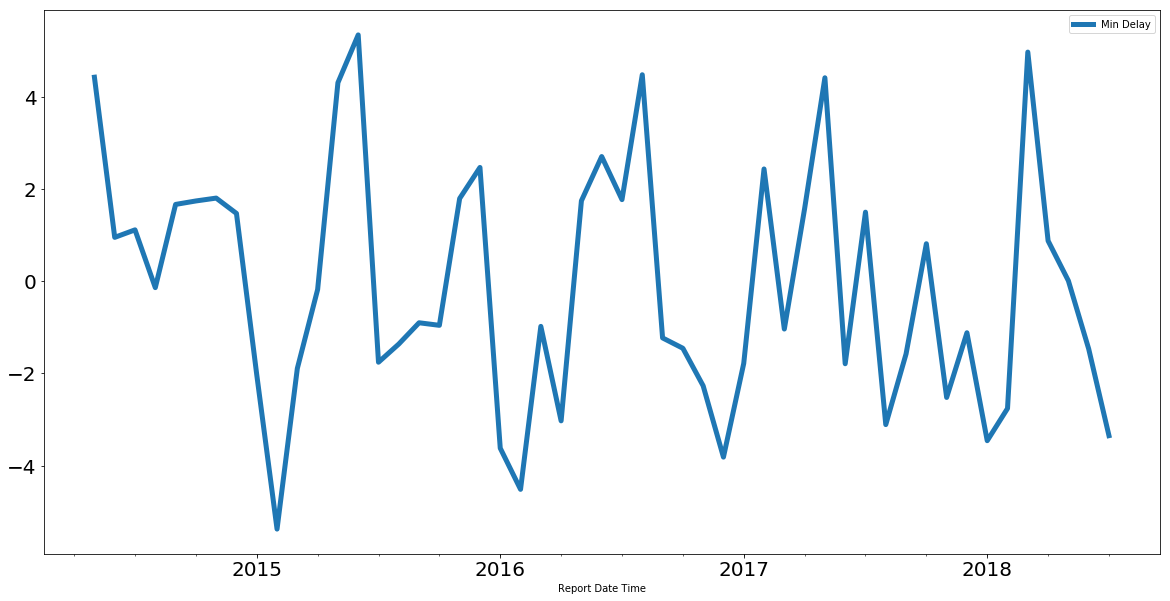

In [97]:
# using 1st discrete difference of object
# This gives us idea about variation of data for a period of time.
mean_delay.diff(periods=4).plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

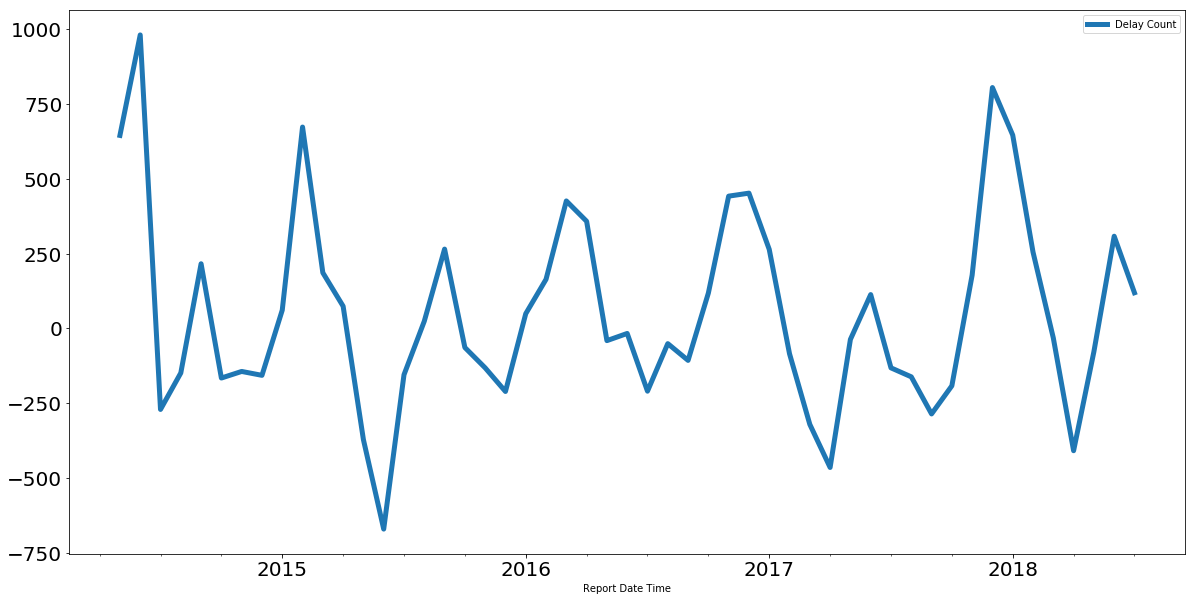

In [98]:
count_delay.diff(periods=4).plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

Auto correlation is the most famous way to understand seasonal variation till now. We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.In this plot vertical axis is represented by the following equations:-

> $C_n = \sum_{t = 1}^{n - h} (y(t) - \hat{y}) (y(t + n) - \hat{y}) / n$

> $C_0 = \sum_{t = 1}^{n} (y(t) - \hat{y})^2 / n$

Horizontal axis represents time lag(previous time steps)  h

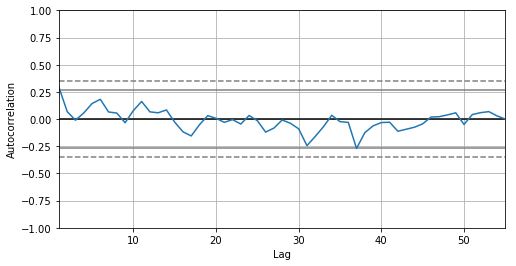

In [99]:
# mean_delay = dfmonthav[['Min Delay']]
# count_delay = dfmonthav[['Delay Count']]


pd.plotting.autocorrelation_plot(dfmonthav['Min Delay'])
plt.show()
# The following curve represents the relation between current time step and its previous time step

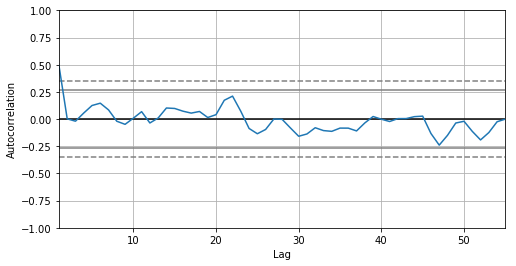

In [100]:
pd.plotting.autocorrelation_plot(dfmonthav['Delay Count'])
plt.show()
# The following curve represents the relation between current time step and its previous time step

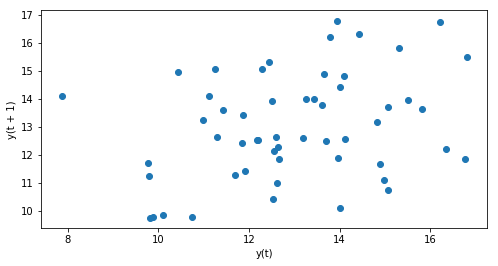

In [101]:
pd.plotting.lag_plot(dfmonthav['Min Delay'])
plt.show()

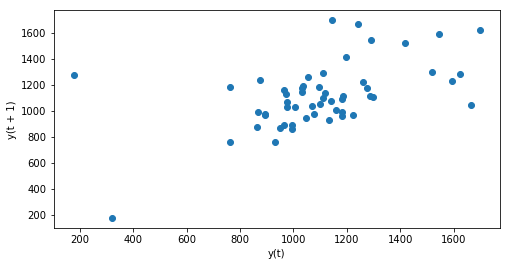

In [102]:
pd.plotting.lag_plot(dfmonthav['Delay Count'])
plt.show()

In [103]:
# df = df.set_index('YEAR_MONTH_SALE_DATE')

## Applying Seasonal ARIMA model to forcast the data 

In [104]:
# try enforce_stationarity and enforce_invertibility to false
# mod = sm.tsa.SARIMAX(dfmonthav['Min Delay'], trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
mod = sm.tsa.SARIMAX(dfmonthav['Delay Count'], trend='n', order=(0,1,0), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility = False)

results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        Delay Count   No. Observations:                   55
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -465.609
Date:                            Mon, 29 Oct 2018   AIC                            937.217
Time:                                    16:19:27   BIC                            943.239
Sample:                                01-31-2014   HQIC                           939.546
                                     - 07-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.7935          0        inf      0.000       0.794       0.794
ma.S.L12   -6.208e+13          0   

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/statsmodels/tsa/statespace/mlemodel.py:1964: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/linalg/linalg.py:1502: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


In [105]:
# try enforce_stationarity and enforce_invertibility to false
# mod = sm.tsa.SARIMAX(dfmonthav['Min Delay'], trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
mod = sm.tsa.SARIMAX(dfmonthav['Min Delay'], trend='n', order=(0,1,0), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility = False)

resultsdelay = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        Delay Count   No. Observations:                   55
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -465.609
Date:                            Mon, 29 Oct 2018   AIC                            937.217
Time:                                    16:19:27   BIC                            943.239
Sample:                                01-31-2014   HQIC                           939.546
                                     - 07-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.7935          0        inf      0.000       0.794       0.794
ma.S.L12   -6.208e+13          0   

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/linalg/linalg.py:1502: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


## Evaluation

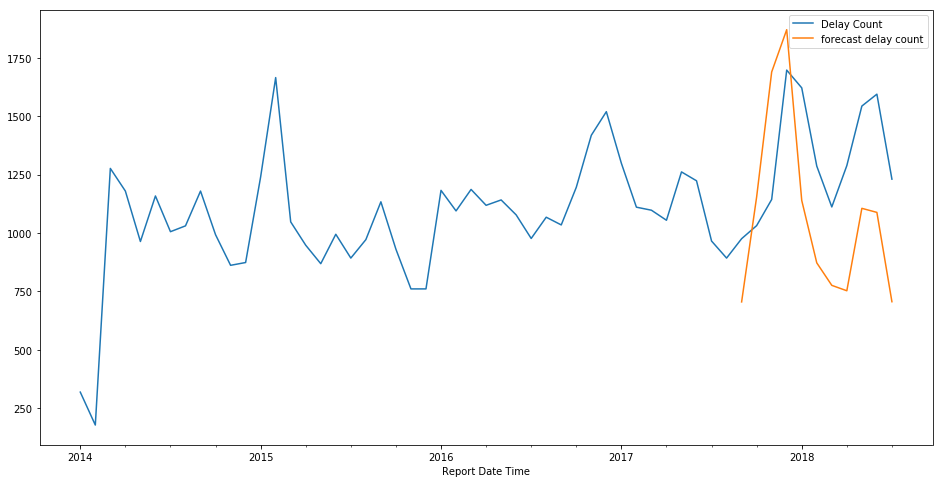

In [106]:
# evaluation of delay count
dfmonthav['forecast delay count'] = results.predict(start = 44, end= 54, dynamic= True)  
dfmonthav[['Delay Count', 'forecast delay count']].plot(figsize=(16, 8))
plt.show()

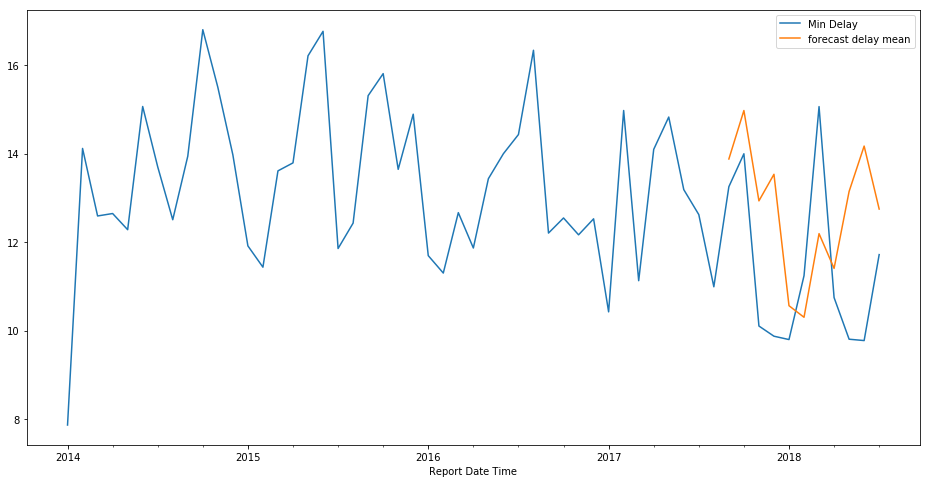

In [107]:
# evaluation of delay mean
dfmonthav['forecast delay mean'] = resultsdelay.predict(start = 44, end= 54, dynamic= True)  
dfmonthav[['Min Delay', 'forecast delay mean']].plot(figsize=(16, 8))
plt.show()

## Generate future forecast

In [108]:
def forcasting_future_months(df, no_of_months, column):
    df_perdict = df.copy()
    mon = df_perdict['Report Date Time']
    mon = mon + pd.DateOffset(months = no_of_months)
    future_dates = mon[-no_of_months -1:]
    df_perdict = df_perdict.set_index('Report Date Time')
    future = pd.DataFrame(index=future_dates, columns= df_perdict.columns)
    df_perdict = pd.concat([df_perdict, future])
    df_perdict['forecast'] = results.predict(start = 38, end = 54, dynamic= True)  
    df_perdict[[column, 'forecast']].iloc[-no_of_months - 12:].plot(figsize=(12, 8))
    plt.show()
    return df_perdict[-no_of_months:]

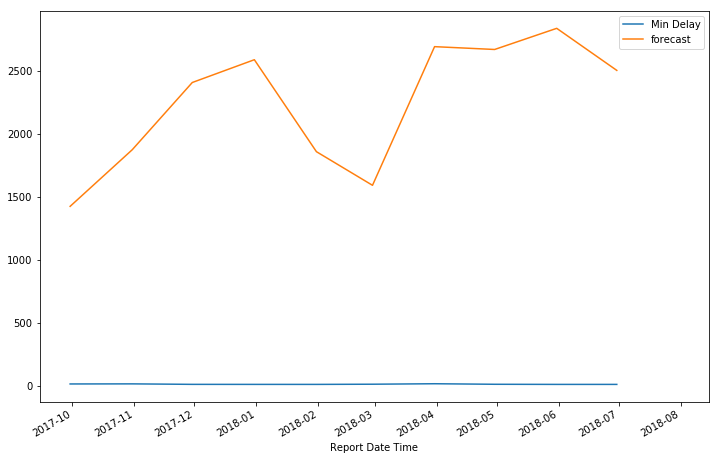

In [109]:
# 'Min Delay' and 'Delay Count'; dfmonthav dataframe
predicted = forcasting_future_months(dfmonthav,10,'Min Delay')

In [ ]:
df.tail()

In [ ]:
def get_day_of_week_sorter():
    sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
    sorterIndex = dict(zip(sorter,range(len(sorter))))
    return(sorterIndex)

In [ ]:
# create index to allow correct sorting of days of the week
def apply_day_sorter(df,sorterIndex):
    df['Day_id'] = df['Day'].map(sorterIndex)
    return(df)
